In [1]:
import os.path
import pickle
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import pandas as pd
import numpy as np
from typing import Optional

import allib
from allib.models.al import ActiveLearningPipeline, RandomMetric, UncertainMetric
from allib.datasets import get_uci_db, load_uci, Dataset
from allib.metrics import get_metrics

from sklearn import preprocessing
from tqdm.notebook import tqdm 
from catboost import CatBoostClassifier, to_classifier, sum_models
importlib.reload(allib)

<module 'allib' from 'E:\\Courses\\COMP8800\\Projects\\CatBoostPlayground\\allib\\__init__.py'>

In [3]:
def model_factory(params: dict):
    def build_model():
        return CatBoostClassifier(
            **params
        )
    return build_model
model_params = {
    "iterations":5,
    "learning_rate":0.1,
    # "cat_features":cat_idx
    # "loss_function":'CrossEntropy'
}
make_model = model_factory(model_params)


In [4]:
class CatBoostPPL(ActiveLearningPipeline):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.extra_params = {
            "cat_features": kwargs.get("cat_idx")
        }
        # self.model_list = []
    # def before_run(self, n_iter: Optional[int] = None):
    #     self.model = make_model()
        
    
    def run(self, n_iter: Optional[int]=None, extra_params: dict={}):
        # prog = tqdm(self.dataset, total=len(self.dataset))
        # prog.set_description(f"The {n_iter+1}th run:")
        self.model = self.model_maker()
        for tx, ty in self.dataset: 
            # new_model = self.model if not self.model_list else make_model()
            self.model.fit(tx, ty, verbose=False, **extra_params)
            # new_model.fit(tx, ty, verbose=False)
            # self.model_list.append(new_model)
            # self.model = self.model_list[0] if len(self.model_list) == 1 else to_classifier(sum_models(self.model_list, weights=[1.0 / len(self.model_list)] * len(self.model_list)))
            self.apply_eval_metrics()
        # self.model_list = []

In [5]:
uci_db = get_uci_db()
print(len(uci_db))

614


In [7]:
(data, label), _, cat_idx = load_uci("adult")

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(label)
label = le.transform(label)

In [6]:
SEEDS = [i+10 for i in range(10)]
params = {
    "init_size": 100,
    "batch_size": 1000
}
random_metric = RandomMetric(**params)
uncertain_metric = UncertainMetric(**params)
rand_dataset = Dataset(data, label, al_metric=random_metric, shuffle=False, **params)
uncert_dataset = Dataset(data, label, al_metric=uncertain_metric, shuffle=False, **params)

In [11]:
# model = make_model()
make_model = model_factory({
    "iterations":5,
    "learning_rate":0.1,
    "cat_features": cat_idx[:-1]
})
# ppl = CatBoostPPL(model=make_model(), seeds=SEEDS, dataset=rand_dataset, eval_metrics=get_metrics(["accuracy"]), n_times=10)
ppl_uncert = CatBoostPPL(model=make_model(), model_maker=make_model, seeds=SEEDS, dataset=uncert_dataset, eval_metrics=get_metrics(["accuracy"]), n_times=10)


In [12]:
ppl_uncert.start()

  0%|          | 0/10 [00:00<?, ?it/s]

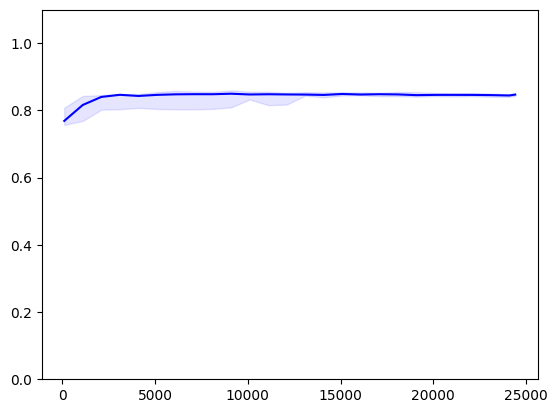

In [19]:
x, a, al, au, _, _ = get_data(ppl_uncert)
fig, ax = plt.subplots()
plot_ppl(x,a,al,au,ax, 'b', "uncert")

In [6]:
def get_al_metric(name: str):
    return {
        "random": RandomMetric,
        "uncertainty": UncertainMetric
    }[name]

In [7]:
import matplotlib.pyplot as plt

In [8]:
def get_data(ppl: ActiveLearningPipeline, minmax:bool=False):
    x = np.array(ppl.stats[0]["instances"])
    acc = np.vstack([ppl.stats[i]["accuracy"] for i in range(ppl.n_times)])
    acc_med = np.median(acc, axis=0)
    acc_max = acc.max(axis=0)
    acc_q3 = np.quantile(acc, .75, axis=0)
    acc_q1 = np.quantile(acc, .25, axis=0)
    acc_min = acc.min(axis=0)
    return (x, acc_med, acc_min, acc_max, acc_q1, acc_q3)

In [18]:
def plot_ppl(x, y_med, y_lower, y_upper, ax, color, label="random"):
    ax.fill_between(x, y_lower, y_upper, color=color, alpha=0.1)
    ax.plot(x, y_med, '-', color=color, label=label)
    ax.set_ylim(0.7, 1.1)
    ax.set_xlim(0, x[int(x.shape[0]/5)+1])

In [10]:
def run_exp(eval_metrics, dataset_name, seeds, al_metric, params: dict, n_runs: int):
    alm = get_al_metric(al_metric)
    alm = alm(**params)
    # uncertain_metric = UncertainMetric(**params)
    (data, label), _, cat_idx = load_uci(dataset_name)
    cat_idx = cat_idx[:-1]
    dataset = Dataset(data, label, al_metric=alm, shuffle=False, **params)
    model_maker = model_factory({
        "iterations":5,
        "learning_rate":0.1,
        "cat_features": cat_idx
    })
    # uncert_dataset = Dataset(data, label, al_metric=uncertain_metric, shuffle=False, **params)
    ppl = CatBoostPPL(model=model_maker(), model_maker=model_maker, seeds=seeds, dataset=dataset, eval_metrics=get_metrics(eval_metrics), n_times=n_runs, cat_idx=cat_idx)
    ppl.start()
    return get_data(ppl)
    
    

In [11]:
# model = make_model()
(data, label), _, cat_idx = load_uci("adult")
make_model = model_factory({
        "iterations":5,
        "learning_rate":0.1,
        "cat_features": cat_idx
})
model = make_model()


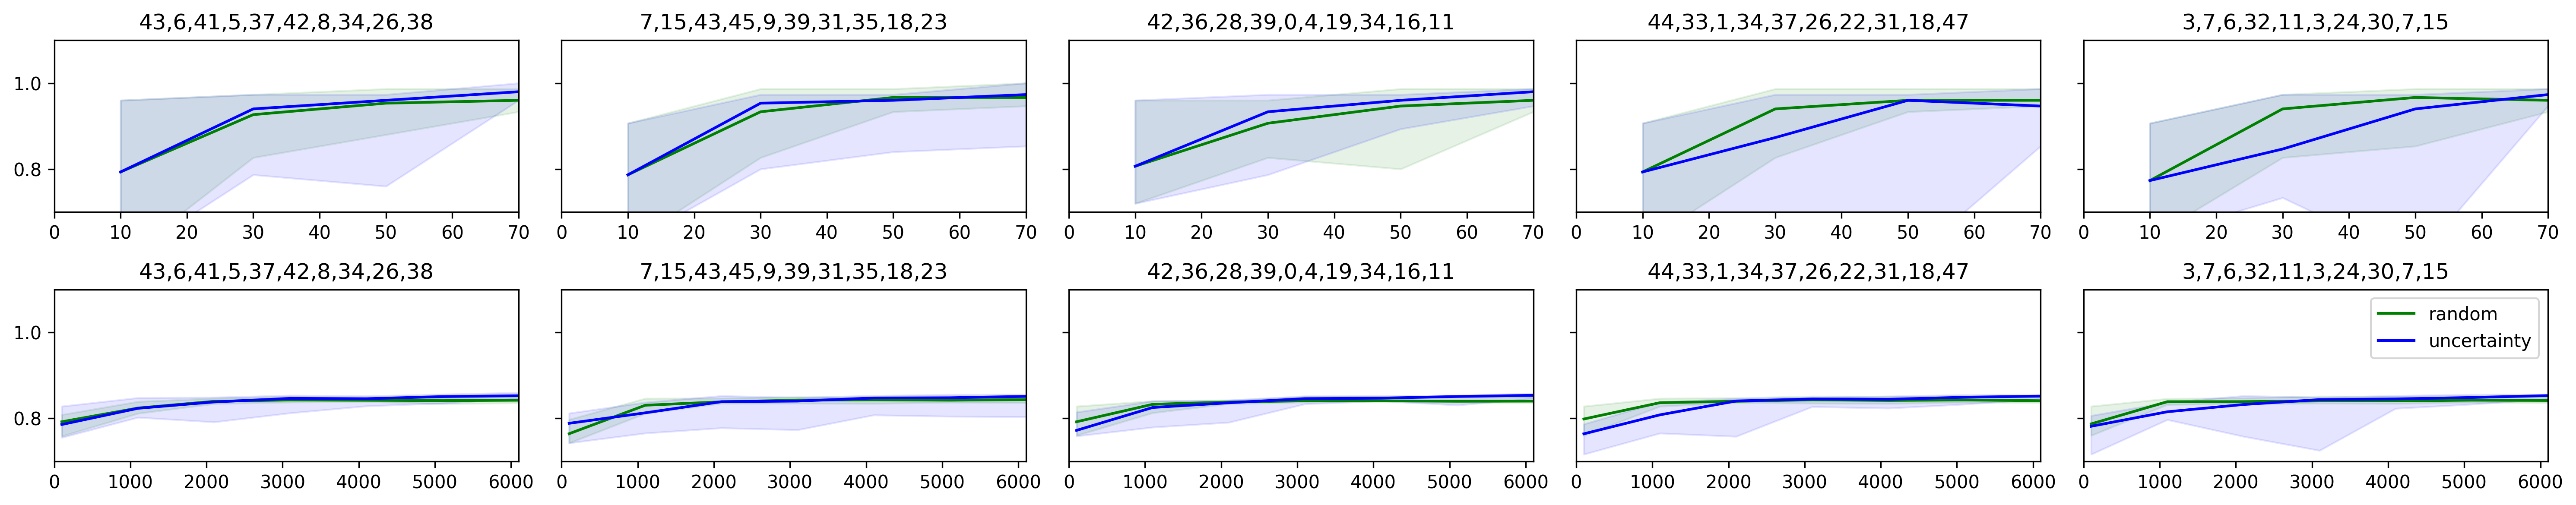

In [19]:
import pickle, os

eval_metrics = ["accuracy"]
dataset_names = ["iris", "adult"]
# al_metrics = ["random"]
al_metrics = ["random","uncertainty"]
n_runs = 10
n_exps = 5
params = {
    "init_size": 100,
    "batch_size": 1000
}
colors = ["g", "b"]
seeds_group = [np.random.randint(0, n_exps * 10, size=(n_runs, )) for _ in range(n_exps)] 
data_dict = {}
# how to save data? 
# todo: build db for data management
fig, axs = plt.subplots(len(dataset_names), n_exps, sharey=True, figsize=(n_exps * 4, 4), dpi=300)

for i in range(n_exps):
    for j, ds in enumerate(dataset_names):
        for k, am in enumerate(al_metrics):
            ax = axs[j, i] if len(dataset_names) > 1 else axs[i]
            ax.set_title(",".join([str(e) for e in seeds_group[i]]))
            key_name = f"{ds}@{'&'.join(eval_metrics)}@{am}@{n_runs}@{i}_of_{n_exps}"
            # data_dict[key_name] = run_exp(eval_metrics, ds, seeds_group[i], am, params, n_runs)
            # # save
            # with open(f"exp_cache/{key_name}", "wb") as f:
            #     pickle.dump(data_dict[key_name], f)
            # load
            if os.path.exists(f"exp_cache/{key_name}"):
                with open(f"exp_cache/{key_name}", "rb") as f:
                    data_dict[key_name] = pickle.load(f)
            x, a, a_lower, a_upper, a_q1, a_q3 = data_dict[key_name]
            plot_ppl(x, a, a_lower, a_upper, ax, colors[k], label=am)
axs[-1,-1].legend()
fig.tight_layout()

In [19]:
x = np.array(ppl.stats[0]["instances"])
acc = np.vstack([ppl.stats[i]["accuracy"] for i in range(10)])
acc_med = np.median(acc, axis=0)
acc_max = acc.max(axis=0)
acc_min = acc.min(axis=0)

acc_un = np.vstack([ppl_uncert.stats[i]["accuracy"] for i in range(10)])
acc_un_med = np.median(acc_un, axis=0)
acc_un_max = acc_un.max(axis=0)
acc_un_min = acc_un.min(axis=0)


In [ ]:
data_dict = {}


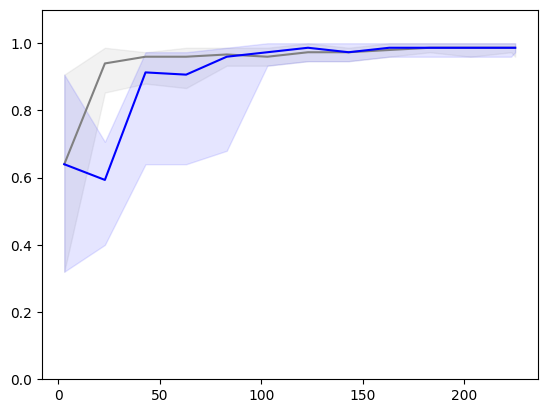

In [47]:
fig, ax = plt.subplots()
plot_ppl(ppl, ax, 'gray', True)
plot_ppl(ppl_uncert, ax, 'b', True)

(0.0, 1.1)

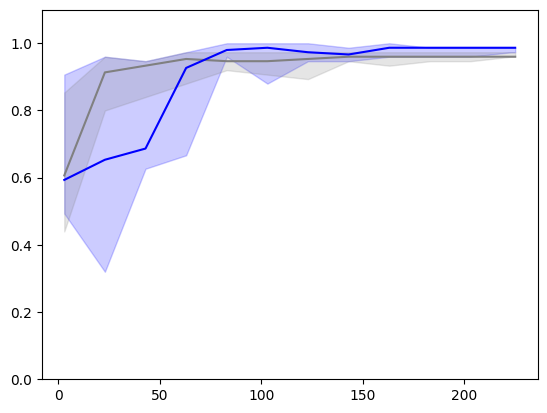

In [20]:
plt.plot(x, acc_med, '-', color='gray')
plt.plot(x, acc_un_med, '-', color='b')
plt.fill_between(x, acc_un_min, acc_un_max,
                 color='b', alpha=0.2)
plt.fill_between(x, acc_min, acc_max,
                 color='gray', alpha=0.2)
plt.ylim(0, 1.1)